# stackview + pyclesperanto_prototype demo
Interactive image stack viewing in jupyter notebooks based on 
[ipycanvas](https://ipycanvas.readthedocs.io/) and 
[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/). 

In this notebook we demonstate its usage on google colab in combination with [pyclesperanto_prototype](https://github.com/clEsperanto/pyclesperanto_prototype).

[Run this notebook in google colab](https://colab.research.google.com/github/haesleinhuepf/stackview/blob/master/docs/colab_clesperanto_demo.ipynb)

## Installation
After starting a new session on google colab, you need to install stackview and pyclesperanto-prototype first. After this, you need to restart the kernel. Use the opportunity to click the menu `Runtime > Change runtime type` and activate the GPU.

Also note: The make stackview work in google colab, you need to install ipycanvas==0.11 ([read why](https://github.com/martinRenou/ipycanvas/issues/170#issuecomment-1119200238)).

In [1]:
!pip install pyclesperanto_prototype stackview ipycanvas==0.11

Again, before going ahead, don't forget to activate the GPU runtime:

<img src="https://biapol.github.io/blog/_images/colab2.png" width="500">

## Usage
First we test the installation by importing the libraries we're going to use

In [2]:
import stackview
import pyclesperanto_prototype as cle
from skimage.io import imread

In [3]:
# Activate widgets in google colab
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
# check which GPU we are using
cle.select_device("cupy")

# why cupy? https://github.com/clEsperanto/pyclesperanto_prototype/issues/300

<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

Starting point is a 3D image dataset provided as numpy array. 

In [5]:
image_stack = imread('https://github.com/clEsperanto/clesperanto_example_data/raw/main/Lund_000500_resampled-cropped.tif?raw=true', plugin='tifffile')

image_stack.shape

(100, 256, 256)

`cle`-images are visualized in jupyer / colab notebooks with a static view. In case the dataset is 3D, we see a maximum-intensity projection.

cl.OCLArray([[[144., 142., 145., ..., 140., 138., 137.],
        [145., 142., 143., ..., 141., 139., 138.],
        [142., 139., 141., ..., 140., 139., 142.],
        ...,
        [256., 252., 260., ..., 308., 287., 273.],
        [253., 249., 253., ..., 319., 298., 278.],
        [256., 255., 253., ..., 322., 296., 273.]],

       [[143., 140., 145., ..., 139., 139., 137.],
        [145., 139., 144., ..., 140., 140., 138.],
        [143., 140., 142., ..., 141., 140., 141.],
        ...,
        [255., 255., 263., ..., 314., 292., 274.],
        [255., 250., 251., ..., 328., 302., 277.],
        [257., 253., 250., ..., 329., 298., 272.]],

       [[143., 139., 145., ..., 139., 139., 137.],
        [145., 138., 145., ..., 139., 141., 137.],
        [143., 140., 142., ..., 142., 141., 141.],
        ...,
        [254., 257., 265., ..., 316., 293., 272.],
        [255., 251., 250., ..., 330., 302., 274.],
        [257., 251., 248., ..., 332., 298., 270.]],

       ...,

       [[137., 138., 140., ..., 128., 127., 129.],
        [140., 140., 137., ..., 131., 127., 129.],
        [140., 138., 138., ..., 129., 130., 133.],
        ...,
        [177., 182., 181., ..., 160., 161., 161.],
        [179., 185., 186., ..., 162., 157., 158.],
        [181., 179., 184., ..., 158., 157., 160.]],

       [[136., 138., 141., ..., 127., 127., 129.],
        [139., 139., 136., ..., 131., 127., 129.],
        [140., 137., 138., ..., 127., 128., 134.],
        ...,
        [175., 179., 179., ..., 158., 159., 159.],
        [177., 182., 184., ..., 162., 155., 158.],
        [180., 174., 180., ..., 158., 157., 158.]],

       [[136., 136., 139., ..., 129., 129., 129.],
        [137., 137., 135., ..., 130., 128., 128.],
        [138., 135., 136., ..., 128., 130., 132.],
        ...,
        [174., 176., 177., ..., 159., 157., 157.],
        [179., 180., 180., ..., 160., 154., 156.],
        [178., 174., 177., ..., 158., 156., 157.]]], dtype=float32)
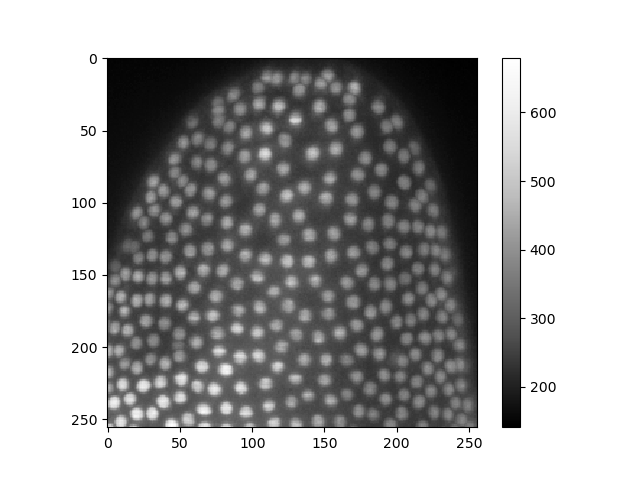
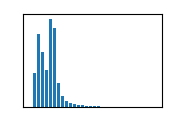

In [6]:
image_stack_on_gpu = cle.asarray(image_stack)

image_stack_on_gpu

## Slicing

We can explore the dataset interactively using `stackview.slice`.

In [7]:
stackview.slice(image_stack_on_gpu)

## Curtain

To compare the original image with a modified version, e.g. after background subtraction, we can use `stackview.curtain`.

In [8]:
background_subtracted = cle.top_hat_box(image_stack_on_gpu, radius_x=10, radius_y=10)

stackview.curtain(image_stack_on_gpu, background_subtracted)

## Interaction

You can also use `sliceview.interact` to explore parameters of functions interactively.

In [9]:
stackview.interact(cle.voronoi_otsu_labeling, background_subtracted)

This may also make sense with custom functions. When writing those it is important to use type-annotations.

In [10]:
def my_custom_segmentation(image, background_subtraction_radius: int = 10, spot_sigma:float = 1, outline_sigma:float = 1, show_labels: bool = True):
    background_subtraction_radius = abs(background_subtraction_radius)
    spot_sigma = abs(spot_sigma)
    outline_sigma = abs(outline_sigma)
    
    background_subtracted = cle.top_hat_box(image, radius_x=10, radius_y=10)

    label_image = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=spot_sigma, outline_sigma=outline_sigma)
    
    edge_image = cle.detect_label_edges(label_image)
    
    if show_labels:
        return label_image
    else:
        return edge_image * 255 + image 

In [11]:
stackview.interact(my_custom_segmentation, image_stack_on_gpu)

## Exercise
Load the blobs image and setup a custom segmentation workflow for segmenting the blobs. Use `stackview.interact` to tune the parameters for the segmentation ([spoiler](https://github.com/haesleinhuepf/stackview/blob/main/docs/demo.ipynb)).

cl.OCLArray([[ 40.,  32.,  24., ..., 216., 200., 200.],
       [ 56.,  40.,  24., ..., 232., 216., 216.],
       [ 64.,  48.,  24., ..., 240., 232., 232.],
       ...,
       [ 72.,  80.,  80., ...,  48.,  48.,  48.],
       [ 80.,  80.,  80., ...,  48.,  48.,  48.],
       [ 96.,  88.,  80., ...,  48.,  48.,  48.]], dtype=float32)
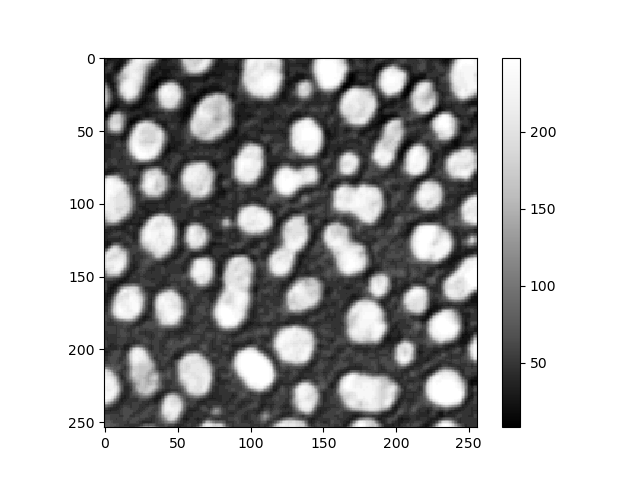
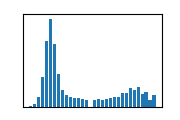

In [12]:
slice_image = imread('https://github.com/haesleinhuepf/stackview/blob/main/docs/data/blobs.tif?raw=true', plugin='tifffile')
cle.asarray(slice_image)